In [ ]:
import sys
sys.path.insert(1,'../')
import pandas as pd
from matplotlib import pyplot as plt

from download import AtlasLightCurveDownloader, ControlCoordinatesTable
from lightcurve import Transient, BaseTransient, BinnedTransient, LightCurve, BinnedLightCurve, BaseLightCurve
from utils import Coordinates, CleanedColumnNames
from clean import LightCurveCleaner
from pdastro import AorB

In [ ]:
VERBOSE = True

# 1. Download (or load) the 2023fyq SN and control light curves

Check out the docstrings for the functions and classes used below for more information.

In [ ]:
# Hardcoded parameters for the example:

# ATLAS credentials:
ATLAS_USERNAME = 'ENTER USERNAME HERE'
ATLAS_PASSWORD = 'ENTER PASSWORD HERE'

# RA and DEC of target object:
RA = 186.44114166666665
DEC = 12.663575

# optionally, change the center of the circle pattern to a nearby bright object
# (else, center will be SN):
CENTER_RA = None
CENTER_DEC = None

# minimum distance from control light curve location to SN location
# (used when center coordinates are not SN coordinates):
SN_MIN_DIST = 3

# radius of circle pattern around center:
RADIUS = 17

# number of control light curves:
NUM_CONTROLS = 8

# lookback time in days:
LOOKBACKTIME = 100

## Option 1: Download from ATLAS API

In [ ]:
center_coords = None
if CENTER_RA is not None and CENTER_DEC is not None:
    center_coords = Coordinates(CENTER_RA, CENTER_DEC)

# create table of control light curve coordinates
control_coords_table = ControlCoordinatesTable(
    Coordinates(RA, DEC),
    center_coords=center_coords,
    sn_min_dist=SN_MIN_DIST,
    radius=RADIUS,
    num_controls=NUM_CONTROLS,
    verbose=VERBOSE
)

# initialize downloader and connect to ATLAS API
downloader = AtlasLightCurveDownloader(
    ATLAS_USERNAME, ATLAS_PASSWORD, verbose=VERBOSE
)

# download SN and control light curves
# get back a Transient object for each filter containing all downloaded light curves
transient_o, transient_c = downloader.download(
    control_coords_table,
    lookbacktime=LOOKBACKTIME,
    max_mjd=None,
    flux2mag_sigmalimit=3,
)

## Option 2: Skip downloading and load the light curves locally

In [6]:
def load(control_index, filt):
    lc = LightCurve(control_index, Coordinates(RA, DEC), filt=filt, verbose=VERBOSE)
    if control_index == 0:
        filename = f"./2023fyq/2023fyq.{filt}.lc.txt"
    else:
        filename = f"./2023fyq/controls/2023fyq_i{control_index:03d}.{filt}.lc.txt"
    print(f"loading control #{control_index}, filt {filt}, filename {filename}")
    df = pd.read_table(filename, sep="\s+")
    lc.set(df, deep=False)
    return lc
transient_o = Transient(filt='o', verbose=VERBOSE)
transient_c = Transient(filt='c', verbose=VERBOSE)
for i in range(0, 9):
    transient_o.add(load(i, 'o'), deep=False)
    transient_c.add(load(i, 'c'), deep=False)
transient_o.preprocess()
transient_c.preprocess()

loading control #0, filt o, filename ./2023fyq/2023fyq.o.lc.txt
loading control #0, filt c, filename ./2023fyq/2023fyq.c.lc.txt
loading control #1, filt o, filename ./2023fyq/controls/2023fyq_i001.o.lc.txt
loading control #1, filt c, filename ./2023fyq/controls/2023fyq_i001.c.lc.txt
loading control #2, filt o, filename ./2023fyq/controls/2023fyq_i002.o.lc.txt
loading control #2, filt c, filename ./2023fyq/controls/2023fyq_i002.c.lc.txt
loading control #3, filt o, filename ./2023fyq/controls/2023fyq_i003.o.lc.txt
loading control #3, filt c, filename ./2023fyq/controls/2023fyq_i003.c.lc.txt
loading control #4, filt o, filename ./2023fyq/controls/2023fyq_i004.o.lc.txt
loading control #4, filt c, filename ./2023fyq/controls/2023fyq_i004.c.lc.txt
loading control #5, filt o, filename ./2023fyq/controls/2023fyq_i005.o.lc.txt
loading control #5, filt c, filename ./2023fyq/controls/2023fyq_i005.c.lc.txt
loading control #6, filt o, filename ./2023fyq/controls/2023fyq_i006.o.lc.txt
loading contro

# 2. Clean the downloaded light curves

In [7]:
# flag value for uncertainty cut:
UNCERTAINTYCUT_FLAG = 0x2
# max uncertainty value:
UNCERTAINTYCUT_VALUE = 160

# flag value for PSF chi-square cut:
CHISQUARECUT_FLAG = 0x1
# max PSF chi-square value:
CHISQUARECUT_VALUE = 10

# flag value for a bad epoch in control light curve cut:
CONTROLSCUT_FLAG = 0x400000

# flag value for a bad day in the bad day cut / binning:
BADDAYCUT_FLAG = 0x800000
# MJD bin size for binning:
MJD_BIN_SIZE = 1.0

In [8]:
cleaner = LightCurveCleaner(verbose=VERBOSE)

# since we have two transient objects, let's just use the 'o' filter (`transient_o`) for now...
# it should take about 40-60s to run this entire cell (i.e., it takes ~40-60s to run the entire cleaning process on 9 full-length o-filter light curves)

# remove any previously added noise in case we rerun this cell multiple times
if transient_o.colnames.has("dflux_offset"):
    transient_o.remove_noise_from_dflux()

# uncertainty cut at 160
transient_o = cleaner.apply_UncertaintyCut(transient_o, flag=UNCERTAINTYCUT_FLAG, max_value=UNCERTAINTYCUT_VALUE)

# true uncertainties estimation
transient_o = cleaner.apply_UncertaintyEstimation(transient_o, uncertainty_cut_flag=UNCERTAINTYCUT_FLAG)

# chi-square cut at 10
transient_o, stats_table = cleaner.apply_ChiSquareCut(transient_o, flag=CHISQUARECUT_FLAG, max_value=CHISQUARECUT_VALUE)

# control light curve cut
previous_flags = cleaner.cut_history.get_primary_flags() # or alternatively: `=UNCERTAINTYCUT_FLAG|CHISQUARECUT_FLAG`
transient_o = cleaner.apply_ControlLightCurveCut(transient_o, previous_flags, flag=CONTROLSCUT_FLAG)

# bad day cut (binning)
previous_flags = cleaner.cut_history.get_primary_flags() # or alternatively: `=UNCERTAINTYCUT_FLAG|CHISQUARECUT_FLAG|CONTROLSCUT_FLAG`
transient_o, binned_transient_o = cleaner.apply_BadDayCut(transient_o, previous_flags, flag=BADDAYCUT_FLAG, mjd_bin_size=MJD_BIN_SIZE)


Applying uncertainty cut of 160

Applying true uncertainties estimation
We can increase the typical uncertainties from 23.50 to 30.50 by adding an additional systematic uncertainty of 19.44 in quadrature
New typical uncertainty is 29.79% greater than old typical uncertainty
Applying true uncertainties estimation
Success
The extra noise was added to the uncertainties of the SN light curve and copied to the "duJy_new" column

Applying chi-square cut of 10
Calculating loss and contamination for chi-square cuts from 3 to 50
Success
Selected chi-square cut of 10.00 has 4.86% contamination and 0.07% loss

Applying control light curve cut
Calculating control light curve statistics
Success

Applying bad day cut and binning with MJD bin size of 1.0 days
Now averaging SN light curve
Now averaging control light curve 1
Now averaging control light curve 2
Now averaging control light curve 3
Now averaging control light curve 4
Now averaging control light curve 5
Now averaging control light curve 6

In [9]:
# we can access a history of cuts applied, like so:
print(cleaner.cut_history)

# now we can view any secondary flags as well as their descriptions
# as well as the percentage of SN measurements flagged with primary flags

-- CUT HISTORY --
Uncertainty Cut:
- 'high_uncertainty' primary flag (hex value 0x2; 3.99% flagged in SN):
	measurement has an uncertainty above 160
True Uncertainties Estimation: We attempt to account for an extra noise source in the data. We estimate the true typical uncertainty, derive the additional systematic uncertainty (19.44), and apply this extra noise to the uncertainty column. We also use a temporary, very high PSF chi-square cut value of 20 to eliminate the most egregious outliers from the data before estimating the true uncertainties.
PSF Chi-Square Cut:
- 'high_psf_chi_square' primary flag (hex value 0x1; 0.40% flagged in SN):
	measurement has a PSF chi-square above 10
Control Light Curve Cut: For a given SN epoch, we can calculate the 3sigma-clipped average of the corresponding N control flux measurements falling within the same epoch. Given the expectation of control flux consistency with zero, the statistical properties accompanying the 3sigma-clipped average enable us

In [10]:
# we can also see the table of chi-square cuts and their contamination and loss:
print(stats_table.t.head().to_string())

# and we can calculate the contamination and loss of any other chi-square cut too
# for example, let's calculate it for some random float:
random_example_cut = 4.453
contamination, loss = stats_table.get_contamination_and_loss(random_example_cut)
print(f"\nChi-square cut of {random_example_cut} has contamination of {contamination:0.2f}% and loss of {loss:0.2f}%")

   PSF Chi-Square Cut      N  Ngood  Nbad  Nkept  Ncut  Ngood,kept  Ngood,cut  Nbad,kept  Nbad,cut  Pgood,kept  Pgood,cut  Pbad,kept  Pbad,cut  Ngood,kept/Ngood     Ploss  Pcontamination
0                   3  25696  24387  1309  23576  2120       22764       1623        812       497   88.589664   6.316158   3.160025  1.934153         93.344815  6.655185        3.444181
1                   4  25696  24387  1309  24815   881       23753        634       1062       247   92.438512   2.467310   4.132939  0.961239         97.400254  2.599746        4.279670
2                   5  25696  24387  1309  25308   388       24141        246       1167       142   93.948474   0.957347   4.541563  0.552615         98.991266  1.008734        4.611190
3                   6  25696  24387  1309  25481   215       24275        112       1206       103   94.469956   0.435866   4.693337  0.400841         99.540739  0.459261        4.732938
4                   7  25696  24387  1309  25559   137       2433

In [11]:
# now let's apply the same procedures to the 'c' filter using the default function:
transient_c, binned_transient_c, _ = cleaner.apply_all_default(
    transient_c, 
    uncertainty_cut=UNCERTAINTYCUT_VALUE, 
    uncertainty_cut_flag=UNCERTAINTYCUT_FLAG, 
    chi_square_cut=CHISQUARECUT_VALUE,
    chi_square_cut_flag=CHISQUARECUT_FLAG,
    controls_cut_flag=CONTROLSCUT_FLAG,
    bad_day_cut_flag=BADDAYCUT_FLAG,
    mjd_bin_size=MJD_BIN_SIZE
)


Applying uncertainty cut of 160

Applying true uncertainties estimation
We can increase the typical uncertainties from 16.00 to 22.30 by adding an additional systematic uncertainty of 15.53 in quadrature
New typical uncertainty is 39.36% greater than old typical uncertainty
Applying true uncertainties estimation
Success
The extra noise was added to the uncertainties of the SN light curve and copied to the "duJy_new" column

Applying chi-square cut of 10
Calculating loss and contamination for chi-square cuts from 3 to 50
Success
Selected chi-square cut of 10.00 has 3.29% contamination and 0.04% loss

Applying control light curve cut
Calculating control light curve statistics
Success

Applying bad day cut and binning with MJD bin size of 1.0 days
Now averaging SN light curve
Now averaging control light curve 1
Now averaging control light curve 2
Now averaging control light curve 3
Now averaging control light curve 4
Now averaging control light curve 5
Now averaging control light curve 6

In [12]:
# and we can view the cut history for filter 'c' too:
print(cleaner.cut_history)

# as well as get the primary flags for any cut we want--for example:
print("\nUncertainty cut flag:", hex(cleaner.cut_history.get_UncertaintyCut_flag().value))
print("\nAll primary flags combined:", hex(cleaner.cut_history.get_primary_flags()))

-- CUT HISTORY --
Uncertainty Cut:
- 'high_uncertainty' primary flag (hex value 0x2; 1.90% flagged in SN):
	measurement has an uncertainty above 160
True Uncertainties Estimation: We attempt to account for an extra noise source in the data. We estimate the true typical uncertainty, derive the additional systematic uncertainty (15.53), and apply this extra noise to the uncertainty column. We also use a temporary, very high PSF chi-square cut value of 20 to eliminate the most egregious outliers from the data before estimating the true uncertainties.
PSF Chi-Square Cut:
- 'high_psf_chi_square' primary flag (hex value 0x1; 0.45% flagged in SN):
	measurement has a PSF chi-square above 10
Control Light Curve Cut: For a given SN epoch, we can calculate the 3sigma-clipped average of the corresponding N control flux measurements falling within the same epoch. Given the expectation of control flux consistency with zero, the statistical properties accompanying the 3sigma-clipped average enable us

# 3. Postprocessing

In [13]:
# now let's combine both filters into one:
final_transient = transient_o.merge(transient_c)
final_binned_transient = binned_transient_o.merge(binned_transient_c)

# and postprocess them for SkyPortal ingestion
# (i.e., match the format you change the raw ATLAS data into in your github):
final_transient.postprocess()
final_binned_transient.postprocess()

# use the get_sn() method to access the SN light curve:
print("Transient:\n",final_transient.get_sn().t.head().to_string())
print("\nBinned transient:\n",final_binned_transient.get_sn().t.head().to_string())

# use the get_good_indices() and get_bad_indices() methods 
# to access the "good" and "bad" indices of the SN light curve
# (remember that some rows will be flagged using secondary flags; 
# they are still considered "good" if not flagged with any primary flag):
good_ix = final_transient.get_sn().get_good_indices(cleaner.cut_history.get_primary_flags())
print("\nCleaned transient:\n",final_transient.get_sn().t.loc[good_ix,:].head().to_string())

# want to remove the secondary flags from the mask column?
# uncomment these lines:
"""
secondary_flags = cleaner.cut_history.get_secondary_flags()
final_transient.get_sn().remove_flag(secondary_flags)
print("\nCleaned transient with secondary flags removed:\n",final_transient.get_sn().t.loc[good_ix,:].head().to_string())
"""

Transient:
             mjd        mag  magerr  flux      dflux  filter         ra       dec  limiting_mag    mask magsys origin
0  57205.272537  18.550302     NaN   -28  49.940796  atlaso  186.44114  12.66357         18.28       0     ab     fp
1  57205.273313  18.396507     NaN   -93  56.454257  atlaso  186.44114  12.66357         18.32       0     ab     fp
2  57205.281246  18.417189     NaN  -117  55.516512  atlaso  186.44114  12.66357         18.27  524288     ab     fp
3  57205.281906  18.024380     NaN    38  64.977558  atlaso  186.44114  12.66357         18.30       0     ab     fp
4  57206.277034  18.438271     NaN   -88  54.580977  atlaso  186.44114  12.66357         18.29  524288     ab     fp

Binned transient:
    mjd_bin     mask          mjd       flux      dflux  filter        mag  magerr magsys origin
0  57205.5        0  57205.27725 -54.362651  27.994392  atlaso  19.089519     NaN     ab     fp
1  57206.5        0  57206.28422 -57.309750  23.793532  atlaso  19.266050 

'\nsecondary_flags = cleaner.cut_history.get_secondary_flags()\nfinal_transient.get_sn().remove_flag(secondary_flags)\nprint("\nCleaned transient with secondary flags removed:\n",final_transient.get_sn().t.loc[good_ix,:].head().to_string())\n'

# 4. Plot

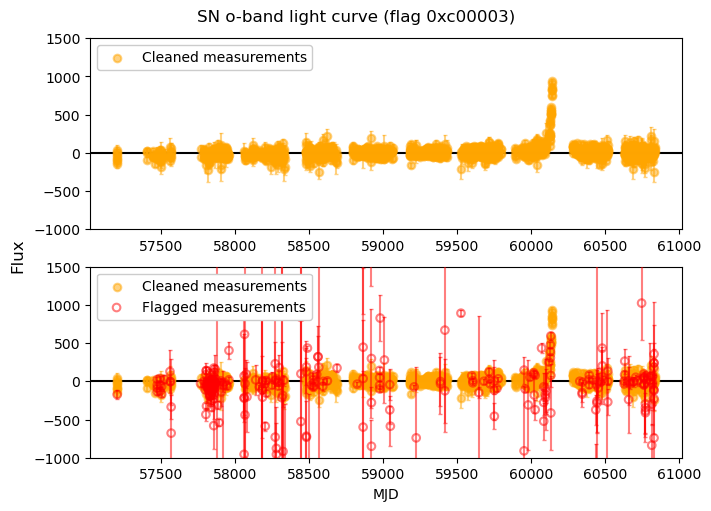

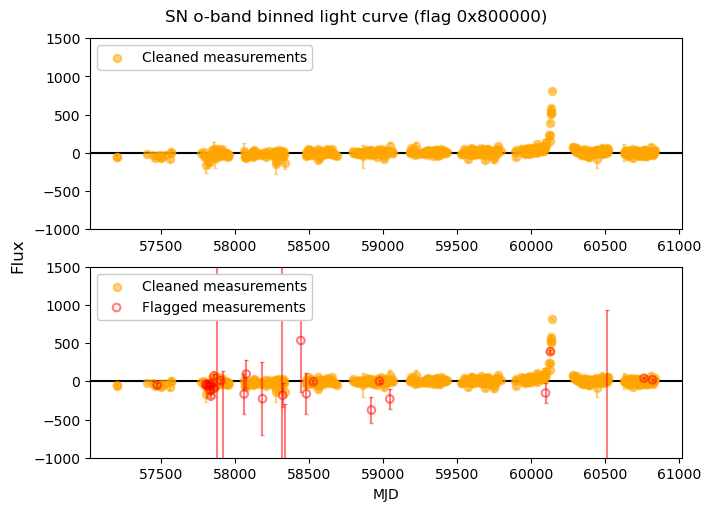

In [14]:
def plot(transient, filt, flags):
    abbrev_filt = filt[-1]
    if abbrev_filt == 'o':
        color = 'orange'
    else:
        color = 'cyan'

    fig, (ax1, ax2) = plt.subplots(2, constrained_layout=True)
    fig.set_figwidth(7)
    fig.set_figheight(5)

    fig.suptitle(f"SN {abbrev_filt}-band{' binned' if isinstance(transient, BinnedTransient) else ''} light curve (flag {hex(flags)})")

    filter_ix = transient.get_sn().get_filt_ix(filt)
    good_ix = transient.get_sn().get_good_indices(flags, indices=filter_ix)
    bad_ix = transient.get_sn().get_bad_indices(flags, indices=filter_ix)
    
    for ax in [ax1, ax2]:
        ax.axhline(color="k", linewidth=1.5, zorder=0)

        ax.errorbar(
            transient.get_sn().t.loc[good_ix, transient.colnames.mjd],
            transient.get_sn().t.loc[good_ix, transient.colnames.flux],
            yerr=transient.get_sn().t.loc[good_ix, transient.colnames.dflux],
            fmt="none", ecolor=color, elinewidth=1.5, capsize=1.2, c=color, alpha=0.5, zorder=10,
        )
        ax.scatter(
            transient.get_sn().t.loc[good_ix, transient.colnames.mjd],
            transient.get_sn().t.loc[good_ix, transient.colnames.flux],
            s=30, lw=1.5, color=color, marker="o", alpha=0.5, zorder=10, label='Cleaned measurements', facecolors=None,
        )

    ax2.errorbar(
        transient.get_sn().t.loc[bad_ix, transient.colnames.mjd],
        transient.get_sn().t.loc[bad_ix, transient.colnames.flux],
        yerr=transient.get_sn().t.loc[bad_ix, transient.colnames.dflux],
        fmt="none", ecolor='r', elinewidth=1.5, capsize=1.2, c='r', alpha=0.5, zorder=10,
    )
    ax2.scatter(
        transient.get_sn().t.loc[bad_ix, transient.colnames.mjd],
        transient.get_sn().t.loc[bad_ix, transient.colnames.flux],
        s=30, lw=1.5, color='r', marker="o", alpha=0.5, zorder=10, label='Flagged measurements', facecolors="none", edgecolors='r',
    )

    fig.supylabel("Flux")
    ax2.set_xlabel("MJD")

    ax1.legend(loc="upper left", facecolor="white", framealpha=1.0).set_zorder(100)
    ax2.legend(loc="upper left", facecolor="white", framealpha=1.0).set_zorder(100)

    for ax in [ax1, ax2]:
        ax.set_ylim(-1000,1500)

plot(final_transient, "atlaso", cleaner.cut_history.get_primary_flags())
plot(final_binned_transient, "atlaso", cleaner.cut_history.get_BadDayCut_flag().value)

# 5. Summary

Below is the complete code for downloading and cleaning.

In [ ]:
import sys
sys.path.insert(1,'../')
import pandas as pd
from matplotlib import pyplot as plt

from download import AtlasLightCurveDownloader, ControlCoordinatesTable
from utils import Coordinates
from clean import LightCurveCleaner
from lightcurve import Transient, BaseTransient, BinnedTransient, LightCurve, BinnedLightCurve

# Hardcoded parameters for the example:

VERBOSE = False

# ATLAS credentials:
ATLAS_USERNAME = 'ENTER USERNAME HERE'
ATLAS_PASSWORD = 'ENTER PASSWORD HERE'

# RA and DEC of target object:
RA = 186.44114166666665
DEC = 12.663575

# optionally, change the center of the circle pattern to a nearby bright object
# (else, center will be SN):
CENTER_RA = None
CENTER_DEC = None

# minimum distance from control light curve location to SN location
# (used when center coordinates are not SN coordinates):
SN_MIN_DIST = 3

# radius of circle pattern around center:
RADIUS = 17

# number of control light curves:
NUM_CONTROLS = 1

# lookback time in days:
LOOKBACKTIME = 100

# flag value for uncertainty cut:
UNCERTAINTYCUT_FLAG = 0x2
# max uncertainty value:
UNCERTAINTYCUT_VALUE = 160

# flag value for PSF chi-square cut:
CHISQUARECUT_FLAG = 0x1
# max PSF chi-square value:
CHISQUARECUT_VALUE = 10

# flag value for a bad epoch in control light curve cut:
CONTROLSCUT_FLAG = 0x400000

# flag value for a bad day in the bad day cut / binning:
BADDAYCUT_FLAG = 0x800000
# MJD bin size for binning:
MJD_BIN_SIZE = 1.0

In [ ]:
center_coords = None
if CENTER_RA is not None and CENTER_DEC is not None:
    center_coords = Coordinates(CENTER_RA, CENTER_DEC)

# create table of control light curve coordinates
control_coords_table = ControlCoordinatesTable(
    Coordinates(RA, DEC),
    center_coords=center_coords,
    sn_min_dist=SN_MIN_DIST,
    radius=RADIUS,
    num_controls=NUM_CONTROLS,
    verbose=VERBOSE
)

# initialize downloader and connect to ATLAS API
downloader = AtlasLightCurveDownloader(
    ATLAS_USERNAME, ATLAS_PASSWORD, verbose=VERBOSE
)

# download SN and control light curves
# get back a Transient object for each filter containing all downloaded light curves
transient_o, transient_c = downloader.download(
    control_coords_table,
    lookbacktime=LOOKBACKTIME,
    max_mjd=None,
    flux2mag_sigmalimit=3,
)

In [ ]:
cleaner = LightCurveCleaner(verbose=VERBOSE)

# clean 'o' filter
transient_o, binned_transient_o, _ = cleaner.apply_all_default(
    transient_o, 
    uncertainty_cut=UNCERTAINTYCUT_VALUE, 
    uncertainty_cut_flag=UNCERTAINTYCUT_FLAG, 
    chi_square_cut=CHISQUARECUT_VALUE,
    chi_square_cut_flag=CHISQUARECUT_FLAG,
    controls_cut_flag=CONTROLSCUT_FLAG,
    bad_day_cut_flag=BADDAYCUT_FLAG,
    mjd_bin_size=MJD_BIN_SIZE
)

# clean 'c' filter
transient_c, binned_transient_c, _ = cleaner.apply_all_default(
    transient_c, 
    uncertainty_cut=UNCERTAINTYCUT_VALUE, 
    uncertainty_cut_flag=UNCERTAINTYCUT_FLAG, 
    chi_square_cut=CHISQUARECUT_VALUE,
    chi_square_cut_flag=CHISQUARECUT_FLAG,
    controls_cut_flag=CONTROLSCUT_FLAG,
    bad_day_cut_flag=BADDAYCUT_FLAG,
    mjd_bin_size=MJD_BIN_SIZE
)

# combine both filters into one
final_transient = transient_o.merge(transient_c)
final_binned_transient = binned_transient_o.merge(binned_transient_c)

# postprocess them for SkyPortal ingestion
final_transient.postprocess()
final_binned_transient.postprocess()